# Constructing the likelihood of cosmological parameters using MCMC chain: M-H vs. A-I method

In this IJulia notebook, I show how MCMC chains work to evaluate the likelihood of cosmological parameters

The cosmic microwave background (CMB) is electromagnetic radiation as a remnant from an early stage of the universe in the standard cosmology. The use of CMB observation enables us to explore the evolution of the Universe and temperatures at all angular positions are measured for this study. There are 6 parameters which descibe the evolution of the cosmic structure and the paramters with relavant physical models constraint the angular distribution of temperature. The cosmological parameters are:
> - **Ω_b**: density of baryonic matter
- **Ω_cdm**: density of cold dark matter (cdm)
- **τ_reio**: optical depth at the epoch of reionization
- **θ_s**: the angular scale of the sound horizon at matter-radiation equality
- **A_s**: curvature perturbations
- **n_s**: scalar spectral index.



The finite-dimensional distribution (hearafter f.d.d. data is discretely spaced in the units of pixel) of cosmic temperature follow a Gaussian random process. The observed data consist of: 
$$
\begin{align*}
d(\hat{n}) = T(\hat{n}) + {\large \epsilon} (\hat{n}) 
\end{align*}
$$
where d($\hat{n}$) is data , T($\hat{n}$) $\sim (0,\Sigma^{TT}(\vec{p}))$ is model temperature, 
${\large \epsilon}$($\hat{n}$) $\sim (0,\Sigma^{\epsilon\epsilon})$ is noise bias, and $\hat{n}$ is angular position vector. 

Acutally, the temperature we observe is PSF-convolved one. Therefore,
$$
\begin{align*}
& d(\hat{n}) = \phi * T(\hat{n}) + {\large \epsilon}(\hat{n}) & :\text{general expression}\\
\Longleftrightarrow &d_{lm} = (\phi * T)_{lm} + {\large \epsilon}_{lm} & :\text{expressed in spherical harmonics on S}^2
\end{align*}     
$$
where $\phi$ is a Gaussian beam PSF on $S^2$.

Dividing by the beam and renaming $d_{lm}$ & ${\large \epsilon}_{lm}$ gives a general model for observation:
$$
\begin{align*}
d_{lm} = T_{lm} + {\large \epsilon}_{lm} \ \ \ {\rm for }\ l=\ \text{0,1,2,} \cdots \text{, and }\ m=-l,-l+1,\cdots,l-1,l
\end{align*}     
$$
where $E(T_{lm}\cdot\overline{T_{l'm'}})=\delta_{ll'}\delta_{mm'}C_l^{TT},
E({\large \epsilon}_{lm}\cdot\overline{{\large \epsilon}_{l'm'}})
=\delta_{ll'}\delta_{mm'}C_l^{\epsilon\epsilon}
= \delta_{ll'}\delta_{mm'}\sigma^2\exp\bigg(\frac{b^2}{8\log 2}l(l+1)\bigg),\sigma$ is addictive noise level, and $b$ is FWHM of the PSF.


# Getting Started: reading data & initializing paramters

As the first step of our analysis, I read a set of 9-year WMAP data with estimated cosmological paramters and fully available  MCMC chain (Hinshaw et al. 2013). The mean of each parameter data is the best estimate by WMAP observation.

In [1]:
using HDF5, PyCall, PyPlot, Distributions, NLopt

path = "/Users/inchanji"
run(`head $path/wmap_lcdm_wmap9_chains_v5/omegach2`);
nlines = countlines("$path/wmap_lcdm_wmap9_chains_v5/omegach2");

nchain = 100_000
omega_b_chain     = readdlm("$path/wmap_lcdm_wmap9_chains_v5/omegabh2")[1:nchain,2]
omega_cdm_chain   = readdlm("$path/wmap_lcdm_wmap9_chains_v5/omegach2")[1:nchain,2]
tau_reio_chain    = readdlm("$path/wmap_lcdm_wmap9_chains_v5/tau")[1:nchain,2]
theta_s_chain     = readdlm("$path/wmap_lcdm_wmap9_chains_v5/thetastar")[1:nchain,2]
A_s_109_chain     = readdlm("$path/wmap_lcdm_wmap9_chains_v5/a002")[1:nchain,2]  # <-- 10⁹ * A_s
n_s_chain         = readdlm("$path/wmap_lcdm_wmap9_chains_v5/ns002")[1:nchain,2]

full_chain        = hcat(omega_b_chain, omega_cdm_chain, tau_reio_chain, theta_s_chain, A_s_109_chain, n_s_chain);
wmap_chain        = copy(full_chain)
names_chain       = [:omega_b, :omega_cdm, :tau_reio, :theta_s, :A_s_109, :n_s];

const σ² = (10.0/3437.75)^2;    # <---10μkarcmin noise level converted to radian pixels (1 radian = 3437.75 arcmin)
const b² = (0.0035)^2;          # <-- FWHM of 0.2ᵒ ≈ 12.0 armin ≈ 0.0035 radians          

const Σwmap             = cov(full_chain);
const bandpowers = h5read("$path/bandpowers.h5", "bandpowers");

const lcdm_sim_truth = h5read("$path/lcdm_sim_truth.h5", "lcdm_sim_truth")
@pyimport pypico
const picoload = pypico.load_pico("$path/pico3_tailmonty_v34.dat")


wmap_best_fit = vec(mean(full_chain,1))
[names_chain wmap_best_fit]

1       0.117062874352432095
2       0.108967379062375080
3       0.109528409355401521
4       0.101409184716838671
5       0.104083078229435091
6       0.107187006794221051
7       0.112446837434475005
8       0.107616613742339856
9       0.111562053244599030
10      0.111868995879391156


6x2 Array{Any,2}:
 :omega_b    0.022635 
 :omega_cdm  0.113854 
 :tau_reio   0.0889852
 :theta_s    0.0103905
 :A_s_109    2.41154  
 :n_s        0.972309 

# Defining essential functions to calculate the likelihood of parameters from the observation data.

"pico" function calculates the CMB power spectrum as a function of bandwidth (moments) based on a set of cosmological parameters.

In [2]:
function pico(x::Array{Float64,1})     
    omega_b     = x[1]
    omega_cdm   = x[2]
    tau_reio    = x[3]
    theta_s     = x[4]
    A_s_109     = x[5]
    n_s         = x[6]
    plout::Dict{ASCIIString, Array{Float64,1}} = picoload[:get](;
        :re_optical_depth => tau_reio,
        symbol("scalar_amp(1)") =>  1e-9*A_s_109,
        :theta => theta_s,
        :ombh2 => omega_b,
        :omch2 => omega_cdm,
        symbol("scalar_spectral_index(1)") => n_s,
        :massive_neutrinos => 3.04,
        :helium_fraction => 0.25,
        :omnuh2 => 0.0,
        symbol("scalar_nrun(1)") => 0.0,
        :force     => true
    )
    # The output of picoload is a dictionary with a bunch of spectral densities, i.e., clTT. 
    # However, here we only return clTT value.
    clTT::Array{Float64,1} = plout["cl_TT"]
    ells   = 0:length(clTT)-1
    clTT .*= 2π ./ ells ./ (ells + 1)
    # Note: the CMB spectral densities already have a factor ell(ell+1)/(2pi).
    clTT[1] = 0.0
    return clTT
end

pico (generic function with 1 method)

# Defining Log likelihood of posterior and proposal. 
Since my choice of proposal is symmetric, I will ignore it. 

In [3]:
function LogPost(θ::Array{Float64,1})
    ClTT = pico(θ)
    ell  = 0:length(ClTT)-1
    Cldd = ClTT + σ² * exp(b² .* ell .* (ell + 1) ./ (8log(2)))
    rtn = 0.0
    @inbounds for l in ell[2:end]    # change 2 -> 3,  l=1 "dipole"
      rtn -= log(Cldd[l+1]) * (2l+1) / 2
      rtn -= (bandpowers[l+1] / Cldd[l+1]) * (2l+1) / 2
    end
    return rtn
end


function Pprop(θ1::Array{Float64,1},θ2::Array{Float64,1})
    d = length(θ1)
    return exp(-0.5 .* transpose(θ1-θ2) * (Σwmap\ (θ1-θ2))) ./ √( (2π)^d * det(Σwmap))
end
   

Pprop (generic function with 1 method)

# Constraining bounds for parameter search and max. time for MCMC run.

In [4]:
llmin(x,grad)  = LogPost(x)
algm = [:LN_BOBYQA, :LN_COBYLA, :LN_PRAXIS, :LN_NELDERMEAD, :LN_SBPLX]
opt = Opt(algm[1], 6)
upper_bounds!(opt, [0.034, 0.2,  0.55,  .0108, exp(4.0)/10,  1.25])
lower_bounds!(opt, [0.018, 0.06, 0.01,  .0102, exp(2.75)/10, 0.85])  # <-- pico training bounds
maxtime!(opt, 5*60.0)   # <--- max time in seconds
max_objective!(opt, llmin)
optf, optx, ret = optimize(opt, wmap_best_fit)

(-3.896796090452089e8,[0.02247874726318284,0.10811925892802669,0.0780899335694353,0.010400367948677961,2.2581318865051263,0.9794888952065252],:ROUNDOFF_LIMITED)

# Plotting CMB power spectrum (theoretical band power) using WMAP data

see also to compare plots: https://en.wikipedia.org/wiki/Cosmic_microwave_background#/media/File:PowerSpectrumExt.svg

Power spectrum, a.k.a. CMB anisotropy, is a measure of how the cosmic structure has evolved as a function of (angular) scale up to now. By measuring the temperture fluctuation of the Universe varying angular scale, we can construct the power spectrum. The shape depends on how the Universe evloves, which is well represented by cosmological parameters mentioned above. 

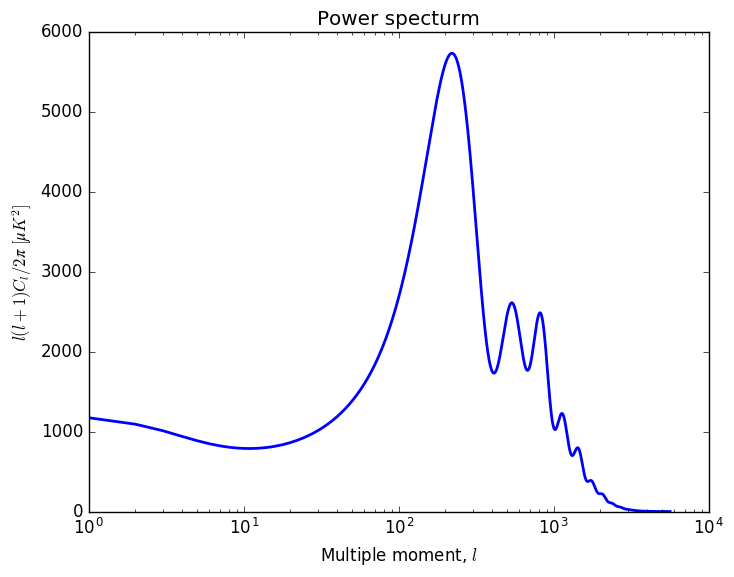

PyObject <matplotlib.text.Text object at 0x31f9f2e50>

In [5]:
ells = collect(0:length(bandpowers)-1) # int. array including: 0 - 5625 = multiple moments.
rawClTT = pico(optx)
semilogx(ells, ells.*(ells+1).* rawClTT ./ (2π), linewidth = 2)
title("Power specturm")
xlabel("Multiple moment, "*L"$l$")
ylabel(L"l(l+1)C_l/2π\ [μK^2]")

In [6]:
hcat(names_chain, optx, lcdm_sim_truth, wmap_best_fit)

6x4 Array{Any,2}:
 :omega_b    0.0224787  0.0223805  0.022635 
 :omega_cdm  0.108119   0.109353   0.113854 
 :tau_reio   0.0780899  0.0759736  0.0889852
 :theta_s    0.0104004  0.0104023  0.0103905
 :A_s_109    2.25813    2.28102    2.41154  
 :n_s        0.979489   0.976015   0.972309 

Compare log likehoods with different sets of cosmological parameters

In [7]:
@show llmin(optx, 0) - llmin(lcdm_sim_truth, 0);
@show llmin(optx, 0) - llmin(wmap_best_fit, 0);

llmin(optx,0) - llmin(lcdm_sim_truth,0) = 0.9888594150543213
llmin(optx,0) - llmin(wmap_best_fit,0) = 61.63154602050781


# Response to varying very small amounts of the cosmological parameters 

The shape of the power spectrum is very sensitive to θs, the angular scale of the sound horizon at matter-radiation equality. Therefore, intial guess of θs should be very rigorously investigated.

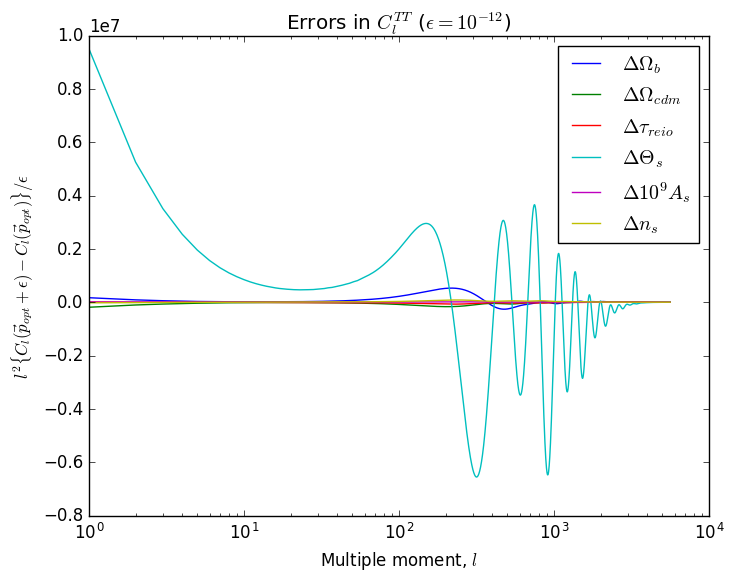

PyObject <matplotlib.text.Text object at 0x33d5ff4d0>

In [8]:
params = [L"$\Omega_b$", L"$\Omega_{cdm}$", L"$\tau_{reio}$",L"$\Theta_s$",L"${10^9 A_s}$",L"$n_s$"]

dϵ = 1e-12
v  = zeros(6)
v[1] = 1
X = zeros(length(bandpowers),6)
for i = 1:6
    X[:,i]   = (pico(optx + dϵ*circshift(v,i-1)) - pico(optx))/dϵ
    param    = params[i]
    semilogx(collect((1:length(bandpowers))).^2 .* X[:,i],label = L"$\Delta$"*"$param")
end
legend()
title("Errors in "*L"C_l^{TT}"*" ("*L"\epsilon = 10^{-12}"*")")
xlabel("Multiple moment, "*L"$l$")
ylabel(L"l^2 \{C_l(\vec{p}_{opt}+\epsilon) - C_l(\vec{p}_{opt})\}/\epsilon")



# Estimating Bayesian posterior

> - **ell**: multiple moemnts, $l$
- **Cldd**: characterizes the angular autocovariance function combining model + noise as a function of moments.
- **Σinv**: inverse covariance matrix of cosmological parameters. It will be used for determining the proposal density.

Formalization of constructing the posterior
(Note: $C_l^{dd}$ = $C_l^{TT} + C_l^{\epsilon\epsilon}$)

1. Gaussian Likelihood is estimated as: 
> 
$$
\begin{aligned}  
\mathcal{P}({\rm d}(\hat{n})\ |\ C_l^{dd}) &= \prod_{l=0}^{l_{\rm max}}\cdot \prod_{m=0}^{l} 
\mathcal{P}(d_{lm}\ |\ C_l^{dd}) 
= \prod_{l=0}^{l_{\rm max}} \mathcal{P}(d_{l0}\ |\ C_l^{dd}) \prod_{m=1}^{l} \mathcal{P}(d_{lm}\ |\ C_l^{dd})\\ 
&\ \ \ \ \ \ \text{note that:}\ Var(d_{lm})= Cov(d_{lm},d_{l'm'})= E(|d_{lm}|^2) - E(d_{lm})^2 = E(|d_{lm}|^2) = C_l^{dd}\\
&\propto \prod_{l=0}^{l_{\rm max}}\frac{1}{\sqrt{C_l^{dd}}} \exp\bigg(-\frac{|d_{l0}|^2}{2C_l^{dd}}\bigg)\cdot
\prod_{m=1}^{l}\frac{\sqrt{2}}{C_l^{dd}} \exp\bigg(-\frac{|d_{lm}|^2}{C_l^{dd}}\bigg)\\
& \vdots \\
&\propto \prod_{l=0}^{l_{\rm max}} \bigg(C_l^{dd}\bigg)^{-\frac{2l+1}{2}}
\exp\bigg(-\frac{2l+1}{2}\frac{\sigma_l}{C_l^{dd}}\bigg)
\end{aligned}  
$$
where $\sigma_l=\frac{1}{2l+1}\sum_{m=-l}^{l}|d_{lm}|^2 = \frac{1}{2l+1}(|d_{l0}|^2+ 2\sum_{m=0}^{l}|d_{lm}|^2)$ is "band power". 
Since the likelihood fators over $l$, one can construct Bayesian posteriors for $C_l^{TT}$ given $\sigma_l$ at each $l$. In particular, one can model the uncertainty in $C_l^{TT}$  with a prior probability distribution, $\Pi(C_l^{TT})$.

2. Bayesian Posterior, $\mathcal{P}(C_l^{TT}|\sigma_l)$ is defined as:
> 
$$
\begin{aligned}
\mathcal{P}(C_l^{TT}|\sigma_l) = \frac{\mathcal{P}(\sigma_l,C_l^{TT})}{\mathcal{P}(\sigma_l)}
=\frac{\mathcal{P}(\sigma_l|C_l^{TT})\Pi(C_l^{TT})}{\int{\rm d}C_l^{TT}\mathcal{P}(\sigma_l,C_l^{TT})}
=\frac{\mathcal{P}(\sigma_l|C_l^{TT})\Pi(C_l^{TT})}{\int{\rm d}C_l^{TT}\Pi(C_l^{TT})\mathcal{P}(\sigma_l|C_l^{TT})}
\end{aligned}
$$
where $\mathcal{P}(\sigma_l|C_l^{TT})$ is likelihood,
$\Pi(C_l^{TT})$ is prior, and 
$\mathcal{P}(\sigma_l) = \int{\rm d}C_l^{TT}\Pi(C_l^{TT})\mathcal{P}(\sigma_l|C_l^{TT})$ is evidence, a normalizing "constant" w.r.t. $C_l^{TT}$.
Using Jeffeys prior, we define the prior as: 
$$
\begin{aligned}
\Pi(C_l^{TT}) &= \sqrt{|\mathcal{F}{(C_l^{TT})}|} \\
&\      \text{where}\ \mathcal{F}\ \text{is Fisher information matrix defined as } 
        \ \mathcal{F}_{ij}({\vec{\mu}})= -E\bigg[\frac{\partial^2}{{\partial \mu_i}{\partial \mu_j}}
        \log\mathcal{L}({\vec{\mu}})\bigg]\  (\text{ where }\ \mathcal{L}({\vec{\mu}}):\text{ likelihood})\\
&= \sqrt{\bigg| -E\bigg[\frac{\rm d^2}{{\rm d}{C_l^{TT}}^2} \log 
\mathcal{P}(\sigma_l\ |\ C_l^{TT},C_l^{\epsilon\epsilon})\bigg]\bigg|}
= \sqrt{\bigg| -E\bigg[\frac{\rm d^2}{{\rm d}{C_l^{TT}}^2} \log 
\prod_{m=0}^{l} \mathcal{P}(d_{lm}\ |\ C_l^{dd})  \bigg]\bigg|} \\
&\propto \sqrt{\bigg| -E\bigg[\frac{\rm d^2}{{\rm d}{C_l^{TT}}^2}
\bigg(-\frac{2l+1}{2}\log(C_l^{TT}+C_l^{\epsilon\epsilon})- 
\frac{2l+1}{2} \frac{\sigma_l}{C_l^{TT}+C_l^{\epsilon\epsilon} }\bigg)\bigg]\bigg|} \\
&=\sqrt{\frac{2l+1}{2}}\frac{1}{C_l^{TT}+C_l^{\epsilon\epsilon}}
\propto \frac{1}{C_l^{TT}+C_l^{\epsilon\epsilon}}
\end{aligned}
$$
$\therefore\ \ \mathcal{P}(C_l^{TT}\ |\ \sigma_l) 
\propto\ \bigg(C_l^{TT}+C_l^{\epsilon\epsilon}\bigg)^{-\frac{2l+1}{2}-1}\cdot
\exp\bigg(-\frac{2l+1}{2}\frac{\sigma_l}{C_l^{TT}+C_l^{\epsilon\epsilon}}\bigg)$

3. Finally, posterior on the cosmological parameters, $\vec{p} = (\Omega_{\rm b},\Omega_{\rm cdm}, \tau_{\rm reio}, \theta_s, A_s,n_s)$ is:
> 
$$
\begin{aligned}
\mathcal{P}(\vec{p}|\vec{d}) &\propto \mathcal{P}(\vec{d}|\vec{p}) \cdot \Pi(\vec{p})\\
&\propto \Pi(\vec{p})\cdot \prod_{l=0}^{l_{\rm max}} \mathcal{P}(C_l^{TT,\vec{p}}|\sigma_l)\\
&= \Pi(\vec{p}) \cdot \prod_{l=0}^{l_{\rm max}} 
\bigg[\bigg(C_l^{TT,\ \vec{p}}+C_l^{\epsilon\epsilon}\bigg)^{-\frac{2l+1}{2}-1}\cdot
\exp\bigg(-\frac{2l+1}{2}\frac{\sigma_l}{C_l^{TT,\vec{p}}+C_l^{\epsilon\epsilon}}\bigg)\bigg]
\end{aligned}
$$


# Choosing proposal density, $\mathcal{P}_\text{prop}(\vec{p}|\vec{p}_\text{curr})$
If one has an idea of the posterior, covariance matrix, and linearity of parameters, a typical choice is:
$$\begin{align*}
\mathcal{P}_\text{prop}(\vec{p}|\vec{p}_\text{curr})\sim \mathcal{N}(\vec{p}_\text{curr}, g\Sigma)
\end{align*}$$
where $g$ is called "$g$-prior" which is tuned to get a good acceptance rate.

1. Linear regression
> If our data model is approximated as:
$$\begin{align*}
\vec{y} & = {\mathbf X}\cdot \vec{\beta} + \vec{\large \epsilon}\\
& = \nabla_\vec{p}C_l^{TT,\vec{p}} \cdot (\vec{p}-\vec{p}_0) + C_l^{\epsilon\epsilon}
\end{align*}$$
where 
${\mathbf X} \rightarrow \nabla_\vec{p}C_l^{TT,\vec{p}}$, $\vec{\beta} \rightarrow \vec{p}-\vec{p}_0$, and 
$\vec{\large \epsilon} \rightarrow Std(\sigma_l)$. 
>
Then, the best estimate of $\vec{\beta}$, i.e., $\hat{\beta}$ is such that:
$$\begin{align*}
\hat{\beta}=  \underset{\vec{b}}{\arg\min}\bigg[
(\vec{y}-{\mathbf X}\cdot\vec{b})^{\intercal}\Omega^{-1}(\vec{y}-{\mathbf X}\cdot\vec{b})
\bigg]
\end{align*}$$
where $E({\large \epsilon}|{\mathbf X}) = 0$, and ${\rm Cov}({\large \epsilon}|{\mathbf X}) = \Omega$; 
the conditional variance of the error term given ${\mathbf X}$ is a known nonsingular matrix ${\mathbf{\Omega}}$. 
$\hat{\beta}$ is estimated by minimizing 
$(\vec{y}-{\mathbf X}\cdot\vec{b})^{\intercal}\Omega^{-1}(\vec{y}-{\mathbf X}\cdot\vec{b})$: 
$$\begin{align*}
\frac{\rm d}{{\rm d}\vec{b}}
\bigg\{(\vec{y}-{\mathbf X}\cdot\vec{b})^{\intercal}\Omega^{-1}(\vec{y}-{\mathbf X}\cdot\vec{b})
\bigg\} = 0.
\end{align*}$$
By solving the equation above, we have:
$\vec{b}=\hat{\beta}=({\mathbf X}^{\intercal}
\Omega^{-1}{\mathbf X})^{-1}{\mathbf X}^{\intercal}\Omega^{-1}\vec{y}$, the best linear unbiased estimator for
$\vec{\beta}$.

2. Estimating $\vec{\beta}$ for a finite sample distribution
>Assuming $\vec{\large \epsilon}\sim\mathcal{N}(0,g\Omega)$, we have:
$$
\begin{align*}
\hat{\beta}&=({\mathbf X}^{\intercal}\Omega^{-1}{\mathbf X})^{-1}{\mathbf X}^{\intercal}\Omega^{-1}\vec{y}
\ \ \ \  \text{where}\ \vec{y}={\mathbf X}\cdot\vec{\beta}+\vec{\large \epsilon}\\
&= \vec{\beta} + {\mathbf X}^{-1}\vec{\large \epsilon}\\
&\ \ \ \ \  \underline{\rm note}\ \  \vec{x} \sim \mathcal{N}(\vec{\mu},\sigma^2= \Sigma)\ \ \ 
\text{where } \Sigma=U\Lambda U^{\intercal}= (U\Lambda^{1/2})(U\Lambda^{1/2})^{\intercal}\\
&\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  = \vec{\mu} + U\Lambda^{1/2}\mathcal{N}(0,I) \ \ \  
\text{where }\ U:\text{orthogonal matrix},\  \Lambda: \text{diag. matrix w/ positive definite (similarity trans.)}\\
&= \vec{\beta} + {\mathbf X}^{-1}\mathcal{N}(0,g\Omega)\\
&=\mathcal{N}(\vec{\beta},g({\mathbf X}^{\intercal}\Omega^{-1}{\mathbf X})^{-1})
\end{align*}
$$
$\therefore \hat{\beta}\sim\mathcal{N}(\vec{\beta},g({\mathbf X}^{\intercal}\Omega^{-1}{\mathbf X})^{-1})$

3. Applying this to our data
> Now the proposal density is estimated as follows:
$$
\begin{align*}
\mathcal{P}_\text{prop}(\vec{p}~|~\vec{p}_\text{curr})
&\sim \mathcal{N}(\vec{p}_\text{curr}, g\Sigma)
= \mathcal{N}(\vec{p}_\text{curr},g ({\mathbf X}^{\intercal}\Omega^{-1}{\mathbf X})^{-1}))\\
&= \mathcal{N}(\vec{p}_\text{curr},g ({\mathbf X}^{\intercal}\Omega^{-1}{\mathbf X})^{-1}))\\
&= \mathcal{N}\bigg(\vec{p}_\text{curr},~g\bigg\{(\nabla_\vec{p}C_l^{TT,\vec{p}})^{\intercal} 
\bigg(\frac{2}{2l+1}(C_l^{TT,\vec{p}}+C_l^{\epsilon\epsilon})^2\bigg)^{-1}(\nabla_\vec{p}C_l^{TT,\vec{p}})
\bigg\} \bigg)
\end{align*}
$$

In [9]:
ell = collect(0:length(bandpowers)-1)
cldd = pico(optx) + σ² * exp(b² .* ell .* (ell + 1) ./ (8log(2)))
Σinv = inv(X' * diagm(1 ./ ( (2./(2*ell+1)) .* cldd.^2)) * X)

6x6 Array{Float64,2}:
  4.61507e-8   -3.08577e-7   4.11336e-6   …   1.08457e-5   8.43693e-7 
 -3.08577e-7    4.12442e-6  -4.2532e-5       -9.08564e-5  -1.07704e-5 
  4.11336e-6   -4.2532e-5    0.00113375       0.00399697   0.000121211
  5.33714e-10  -5.17415e-9   5.7713e-8        1.24148e-7   1.52563e-8 
  1.08457e-5   -9.08564e-5   0.00399697       0.0157949    0.00024258 
  8.43693e-7   -1.07704e-5   0.000121211  …   0.00024258   3.31675e-5 

 Initial guess of LCDM params

In [10]:
θ₀ = [0.022635 , 0.113854 , 0.0889852, 0.0103905, 2.41154, 0.972309 ];

Metropolis–Hastings chain

In [11]:
function MH(θ₀::Array{Float64,1}, Σinv::Array{Float64,2}, g::Float64, N::Int64, NThin::Int64, NBurn::Int64)
    const lcdm_proposal_RV = MultivariateNormal(zeros(6), g*Σinv)
    generate_lcdm_prop(lcdm_curr)  = rand(lcdm_proposal_RV) + lcdm_curr
    
    d      = length(θ₀)
    θcurr  = copy(θ₀)
    LogPostCurr = LogPost(θcurr)
    θprop  = 0.
    acceptance = 0.
    α, u = 0., 0.
    θ      = Array(Float64, N*NThin, d)
    αhist  = Array(Float64, N*NThin)    
    uhist  = Array(Float64, N*NThin)    
    
    println("start burn-in")
    for i=1:NBurn
        θprop  = copy(generate_lcdm_prop(θcurr))
        u = log(rand())
        LogPostProp = LogPost(θprop)
        α = min( LogPostProp - LogPostCurr, 0.) 
        if u <= α
            θcurr       = copy(θprop)
            LogPostCurr = copy(LogPostProp)
        end
    end
        
    println("start MCMC chain")
    percent  = 0.
    for i = 1:N*NThin
        θprop  = copy(generate_lcdm_prop(θcurr))
        u = log(rand())
        LogPostProp = LogPost(θprop)
        α = min( LogPostProp - LogPostCurr, 0.) 
        if u <= α
            θcurr  = copy(θprop)
            LogPostCurr = copy(LogPostProp)
        end

        θ[i,:]   = copy(θcurr[:])
        αhist[i] = copy(exp(α))
        uhist[i] = copy(u)
        
        if i ./ (N*NThin).* 100 > percent
            P_accept = αhist[i]
            println("$percent percent is done. accecptance rate is : $P_accept")
            percent += 5.
        end
    end
    println("MCMC chain is finished.")
    return αhist[NThin:NThin:end], uhist[NThin:NThin:end], θ[NThin:NThin:end,:]
end

MH (generic function with 1 method)

Correlation function which shows how efficiently  algorithms sample data in the parameter space.

In [12]:
function Autocorrelation(x::Array{Float64,1})
    dim = length(x)
    ρ   = Array(Float64, dim) 
    for i=1:dim
        rtn = 0.
        for j = i+1:dim
            if j > i 
                rtn += x[j] .* x[j-i]
            else
                rtn += x[j] .* x[j-i+dim]
            end
        end
        ρ[i] = copy(rtn ./ (dim-1))
    end
    return ρ
end

Autocorrelation (generic function with 1 method)

Run MH chain

In [13]:
g = 0.2
dim = 400
Nthin = 20
Nburn = 100
@time αhist, uhist, θChain = MH(θ₀,Σinv,g,dim,Nthin,Nburn);

start burn-in
start MCMC chain
0.0 percent is done. accecptance rate is : 1.0
5.0 percent is done. accecptance rate is : 0.05891056830466313
10.0 percent is done. accecptance rate is : 0.7799948809452868
15.0 percent is done. accecptance rate is : 0.46274926283459616
20.0 percent is done. accecptance rate is : 0.0012848757132560324
25.0 percent is done. accecptance rate is : 1.0
30.0 percent is done. accecptance rate is : 1.0
35.0 percent is done. accecptance rate is : 0.12991375200996383
40.0 percent is done. accecptance rate is : 1.0
45.0 percent is done. accecptance rate is : 0.23605163056302658
50.0 percent is done. accecptance rate is : 1.0
55.0 percent is done. accecptance rate is : 0.9566466529373552
60.0 percent is done. accecptance rate is : 1.0
65.0 percent is done. accecptance rate is : 0.003240387557617701
70.0 percent is done. accecptance rate is : 0.5366255312475352
75.0 percent is done. accecptance rate is : 0.8957424998463553
80.0 percent is done. accecptance rate is : 

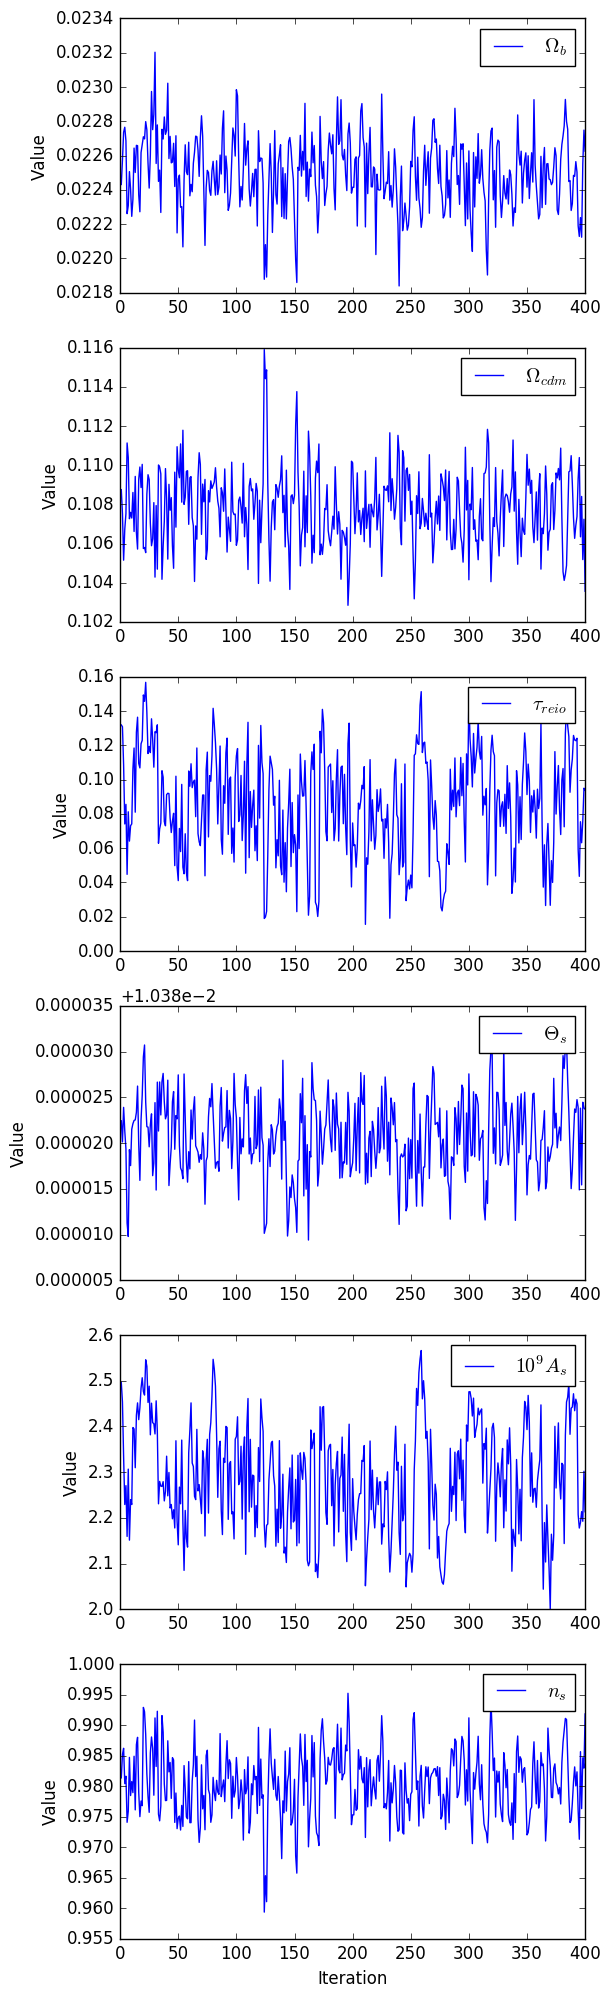

PyObject <matplotlib.legend.Legend object at 0x331abca90>

In [14]:
figure(figsize=(6,24));
i = 1
x = linspace(1, length(θChain[:,i]), length(θChain[:,i]));
subplot(6,1,i)
plot(x,θChain[:,i], label = params[i])
legend(frameon="False")
ylabel("Value")

i +=1
subplot(6,1,i)
plot(x,θChain[:,i], label = params[i])
legend()
ylabel("Value")

i +=1
subplot(6,1,i)
plot(x,θChain[:,i], label = params[i])
legend()
ylabel("Value")

i +=1
subplot(6,1,i)
plot(x,θChain[:,i], label = params[i])
legend()
ylabel("Value")

i +=1
subplot(6,1,i)
plot(x,θChain[:,i], label = params[i])
legend()
ylabel("Value")

i +=1
subplot(6,1,i)
plot(x,θChain[:,i], label = params[i])
legend()
ylabel("Value")
xlabel("Iteration")
legend()

Correlation Function

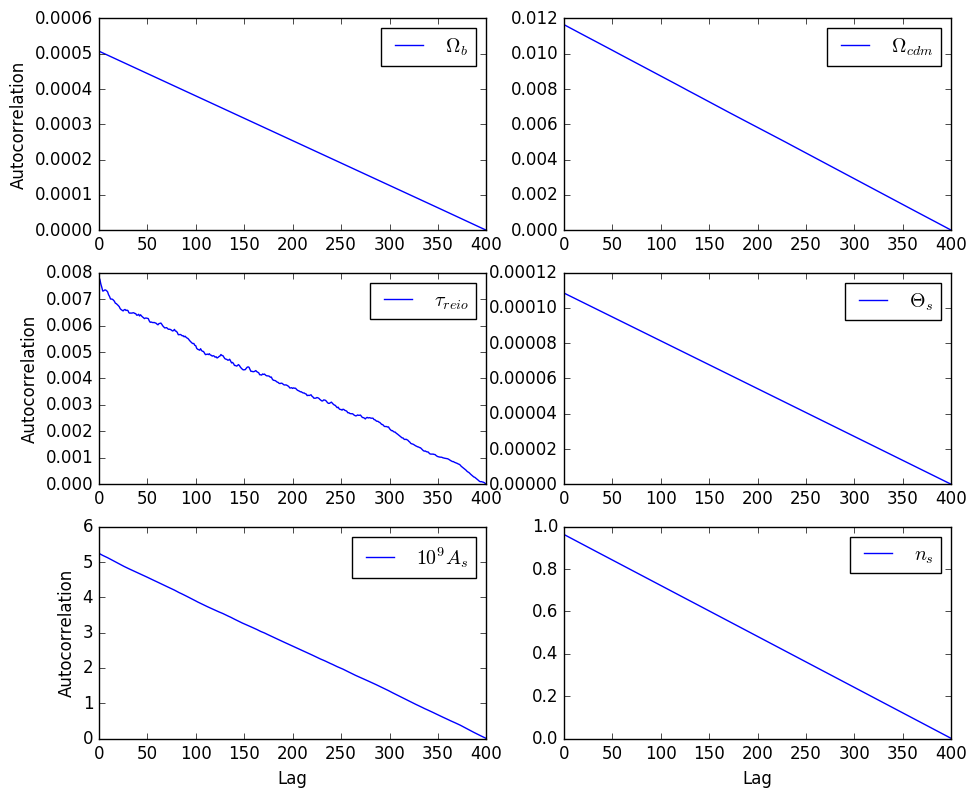

PyObject <matplotlib.legend.Legend object at 0x31d089c10>

In [15]:
figure(figsize=(11,9));

i = 1
subplot(3,2,i)
plot(x,Autocorrelation(θChain[:,i]), label = params[i])
ylabel("Autocorrelation")
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain[:,i]), label = params[i])
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain[:,i]), label = params[i])
ylabel("Autocorrelation")
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain[:,i]), label = params[i])
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain[:,i]), label = params[i])
ylabel("Autocorrelation")
xlabel("Lag")
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain[:,i]), label = params[i])
xlabel("Lag")
legend()


PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x33cc950d0>)

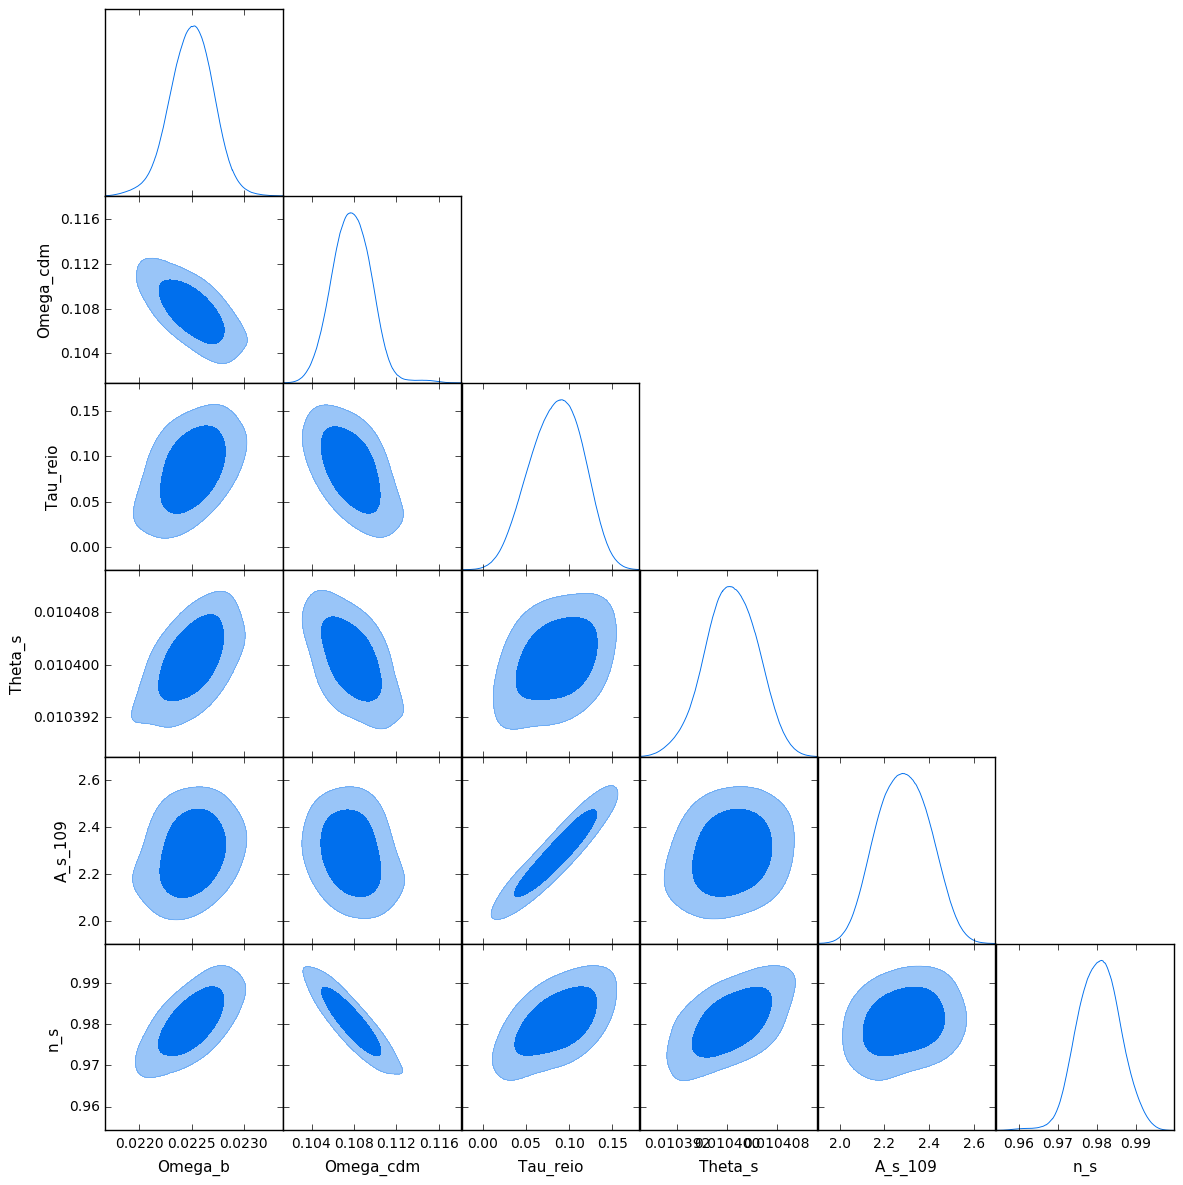

In [16]:
figure(figsize=(9,9));
names_chain   = [:Omega_b, :Omega_cdm, :Tau_reio, :Theta_s, :A_s_109, :n_s]
full_chain    = θChain
@pyimport getdist
@pyimport getdist.plots as plots
samples = getdist.MCSamples(samples=full_chain, names=names_chain)
g = plots.getSubplotPlotter()
g[:triangle_plot](samples, filled=true)

Determining walkers 

In [17]:
Nwalkers = 50
walkers = Array(Float64, Nwalkers, 6)
for i = 1:Nwalkers
    walkers[i,:] = copy(optx) + rand(MultivariateNormal(zeros(6), Σinv))
end
#scatter(walkers[:,1],walkers[:,2])
#grid()

Affine-Invariant chain

In [18]:
function AI(walkers::Array{Float64,2}, a::Float64, N::Int64, NThin::Int64)
    
    Nwalkers = length(walkers[:,1])
    Ntot   = N*Nwalkers
    d      = length(walkers[1,:])
    θ      = Array(Float64, Nwalkers+Ntot, d)
    αhist  = Array(Float64, Nwalkers+Ntot)    
    uhist  = Array(Float64, Nwalkers+Ntot) 
    LogPostWalkers = Array(Float64, Nwalkers)
    θ₀ = Array(Float64, d)
    θprop = Array(Float64, d)

    k = 1
    
    println("start MCMC chain") 
    θ[1:Nwalkers,:] = copy(walkers)    
    for i = 1:N
        walkers  = copy(θ[k:k+Nwalkers-1,:])
        θ[Nwalkers+k:Nwalkers*2+k-1,:] = copy(walkers)
        
        for i=1:Nwalkers
            θ₀[:] = copy(walkers[i,:])
            LogPostWalkers[i] = LogPost(θ₀)
        end
        
        for j = 1:Nwalkers
            z = ((√a - 1/√a) * rand() + 1/√a)^2     #  prop to 1/√z
            ind = rand(1:Nwalkers-1)
            if j >= ind 
                ind += 1
            end
            
            θprop = copy(walkers[ind,:] + z .* (walkers[j,:] - walkers[ind,:]))[:]
            
            u = log(rand())
            LogPostProp = LogPost(θprop)
            α = min( (d-1.)*log(z) + LogPostProp - LogPostWalkers[j], 0.)
            
            if u <= α
                θ[Nwalkers+k,:] = copy(θprop)[:]
            end
            αhist[Nwalkers+k] = copy(exp(α))
            uhist[Nwalkers+k] = copy(exp(u))
            
            k += 1      
        end
        P_accept = αhist[Nwalkers+k-1]
        println("accecptance rate is : $P_accept  ($k /$Ntot)")

        
    end
    println("MCMC chain is finished.")    
    return αhist[Nwalkers:NThin:end], uhist[Nwalkers:NThin:end], θ[Nwalkers:NThin:end,:]
end

AI (generic function with 1 method)

In [19]:
a = 2.
dim = 8
Nthin = 3
@time αhist, uhist, θChain2 = AI(walkers,a,dim,Nthin);

start MCMC chain
accecptance rate is : 0.6868652924208765  (51 /400)
accecptance rate is : 0.06617832771653295  (101 /400)
accecptance rate is : 1.0177328208100237e-5  (151 /400)
accecptance rate is : 0.7862494753655193  (201 /400)
accecptance rate is : 0.3723792996724283  (251 /400)
accecptance rate is : 0.16793369246498568  (301 /400)
accecptance rate is : 3.4018631457045896e-17  (351 /400)
accecptance rate is : 0.25530284075028437  (401 /400)
MCMC chain is finished.
130.665726 seconds (1.64 M allocations: 788.990 MB, 0.19% gc time)


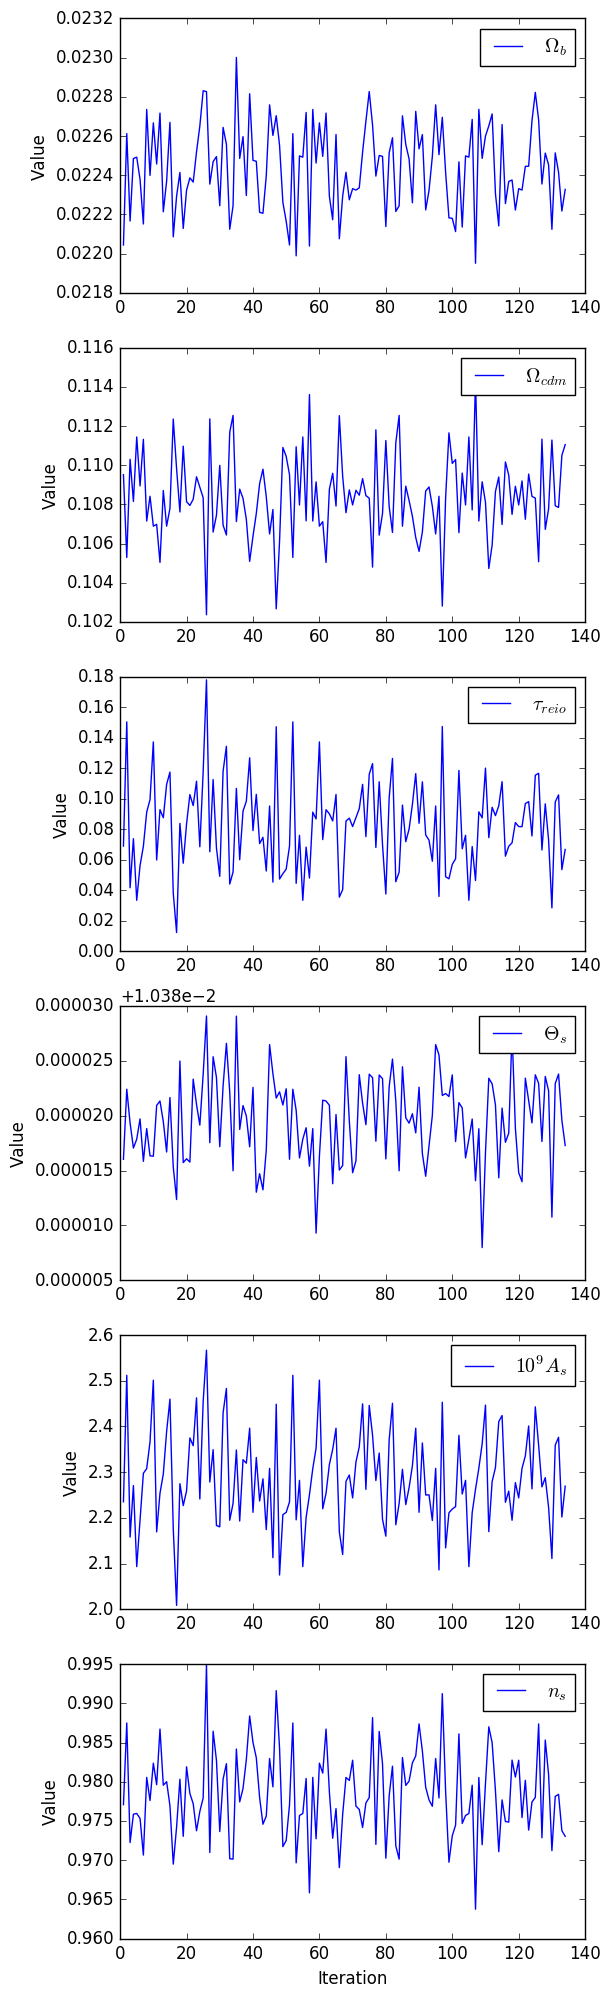

PyObject <matplotlib.legend.Legend object at 0x33d14d290>

In [20]:

figure(figsize=(6,24));
i = 1
x = linspace(1, length(θChain2[:,i]), length(θChain2[:,i]));
subplot(6,1,i)
plot(x,θChain2[:,i], label = params[i])
ylabel("Value")
legend()

i +=1
subplot(6,1,i)
plot(x,θChain2[:,i], label = params[i])
ylabel("Value")
legend()

i +=1
subplot(6,1,i)
plot(x,θChain2[:,i], label = params[i])
ylabel("Value")
legend()

i +=1
subplot(6,1,i)
plot(x,θChain2[:,i], label = params[i])
ylabel("Value")
legend()

i +=1
subplot(6,1,i)
plot(x,θChain2[:,i], label = params[i])
ylabel("Value")
legend()

i +=1
subplot(6,1,i)
plot(x,θChain2[:,i], label = params[i])
legend()
ylabel("Value")
xlabel("Iteration")
legend()

Correlation Function

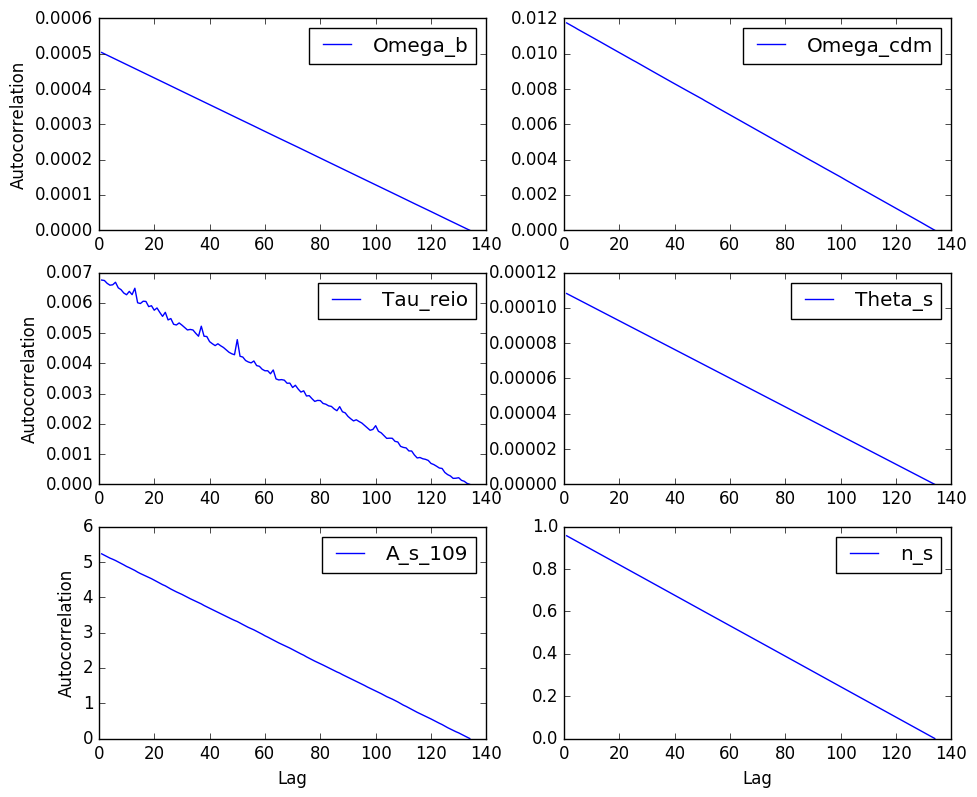

PyObject <matplotlib.legend.Legend object at 0x33e8923d0>

In [21]:
figure(figsize=(11,9));

i = 1
subplot(3,2,i)
plot(x,Autocorrelation(θChain2[:,i]), label = names_chain[i])
ylabel("Autocorrelation")
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain2[:,i]), label = names_chain[i])
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain2[:,i]), label = names_chain[i])
ylabel("Autocorrelation")
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain2[:,i]), label = names_chain[i])
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain2[:,i]), label = names_chain[i])
ylabel("Autocorrelation")
xlabel("Lag")
legend()

i +=1
subplot(3,2,i)
plot(x,Autocorrelation(θChain2[:,i]), label = names_chain[i])
xlabel("Lag")

legend()

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x33976fc10>)

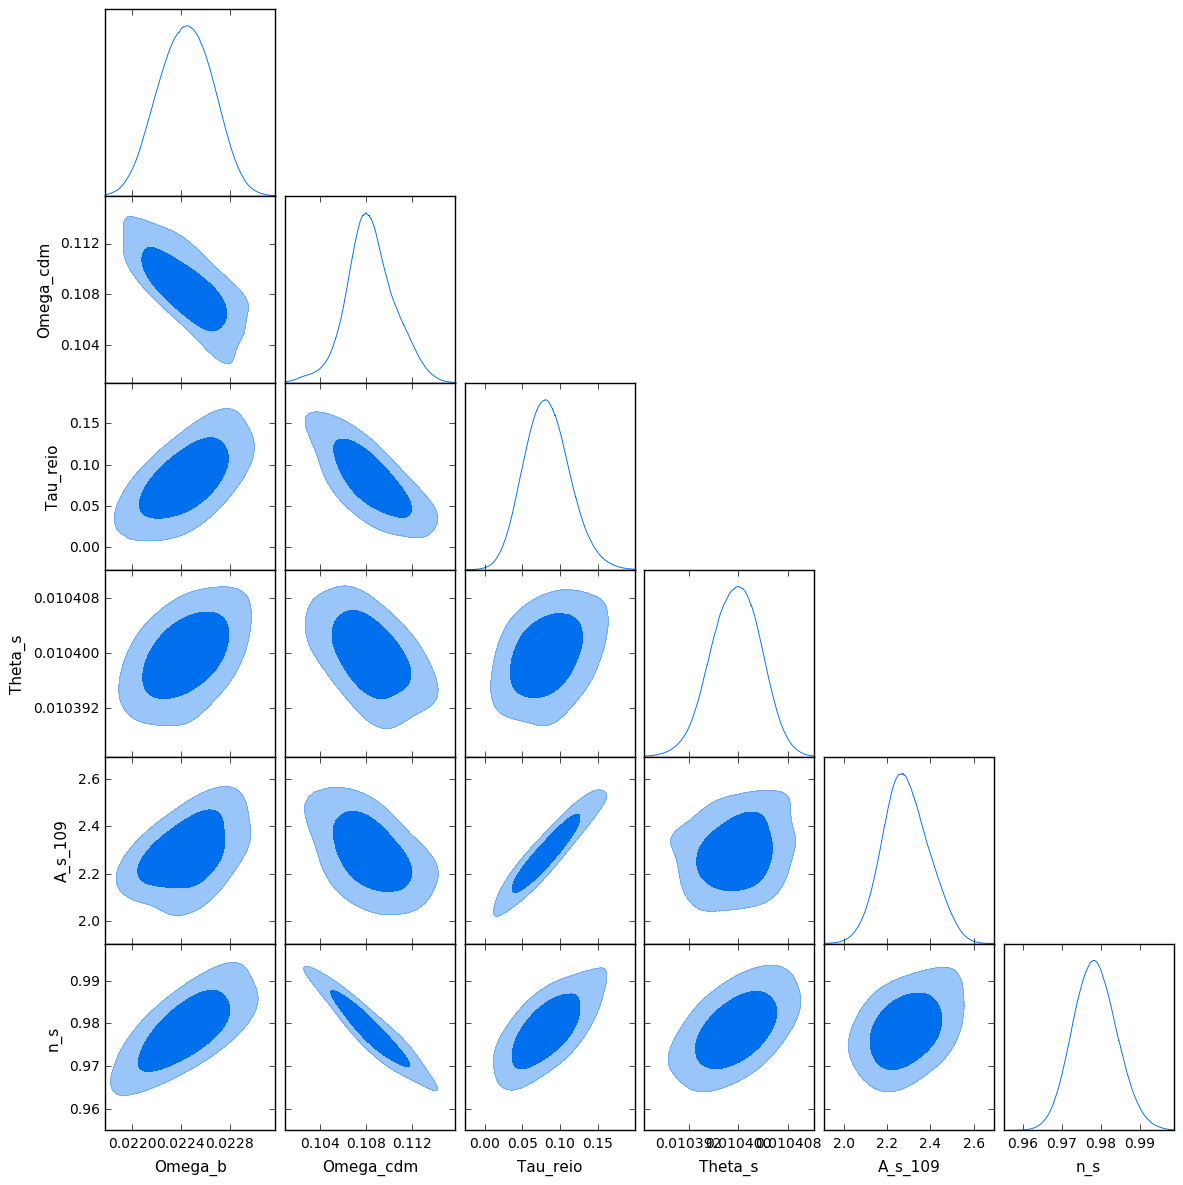

In [22]:
figure(figsize=(9,9));
names_chain   = [:Omega_b, :Omega_cdm, :Tau_reio, :Theta_s, :A_s_109, :n_s]
full_chain    = θChain2
@pyimport getdist
@pyimport getdist.plots as plots
samples = getdist.MCSamples(samples=full_chain, names=names_chain)
g = plots.getSubplotPlotter()
g[:triangle_plot](samples, filled=true)

Probability Distribution of LCDM params for WMAP, MH chain, and AI chain samples.
In this case, MH chain and AI chain have similar distributions because I used the same proposal density when choosing walkers

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x33bb734d0>)

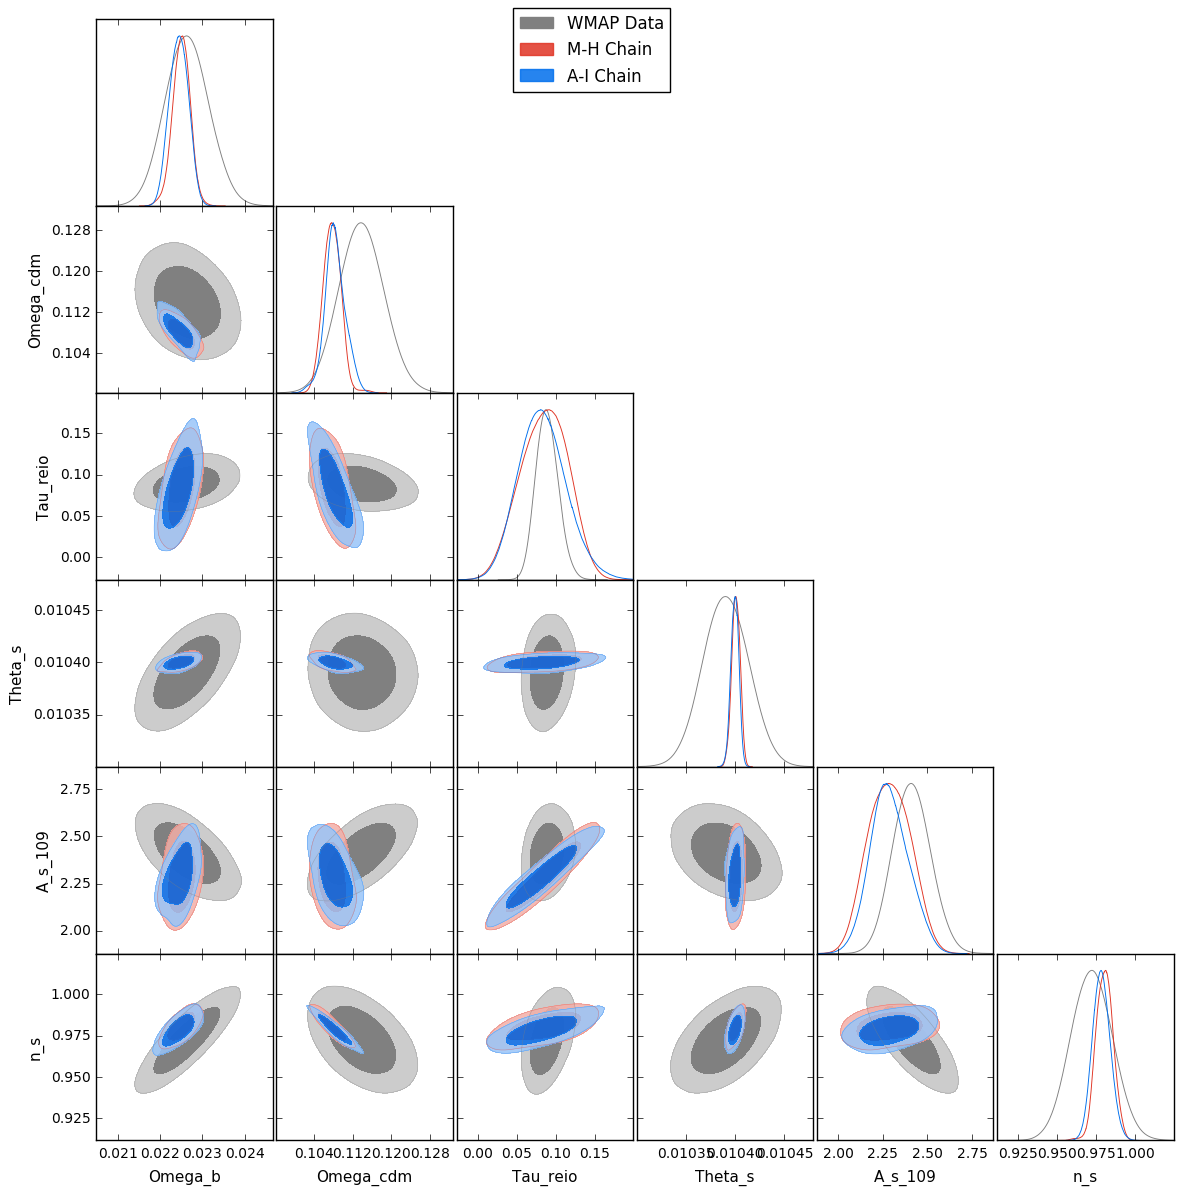

In [23]:
samples0 = getdist.MCSamples(samples=wmap_chain, names=names_chain)
samples1 = getdist.MCSamples(samples=θChain, names=names_chain)
samples2 = getdist.MCSamples(samples=θChain2, names=names_chain)
figure(figsize=(9,9));
g = plots.getSubplotPlotter()
g[:triangle_plot]([samples0, samples1, samples2], filled=true, legend_labels = ["WMAP Data", "M-H Chain", "A-I Chain"])